# GenerativeAdversarial Networks for High-Resolution Image Enhancement
##### Deep Learning course, "Mention SDI"
##### Alexandre Boistard

This project studies how to enhance low-resolution images into high-resolution counterparts using **Generative Adversarial Networks (GANs)**. The **Super-Resolution Generative Adversarial Network (SRGAN)** was a pioneering Deep Learning approach that combined GANs with perceptual loss, enabling the generation of sharper and more realistic images. Despite its success, SRGAN struggled with recovering fine textures and often introduced artifacts in challenging scenarios.

Building upon this, the **Enhanced Super-Resolution Generative Adversarial Network (ESRGAN)** improved image quality significantly by replacing SRGAN’s original building blocks with **Residual-in-Residual Dense Blocks (RRDBs)**. ESRGAN introduced new “basic blocs” as well as a **Relativistic GAN**, enhancing the discriminator’s ability to evaluate realism between real and generated images.

Studying the transition from SRGAN to ESRGAN allows for a better understanding of the motivations behind using this model. This project also aims to highlight some limitations of ESRGAN in practice, which justify the need for further research, broader training, and the introduction of other architectures.

In [8]:
import os
import os.path as osp
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import functools
import torch
import torch.nn as nn
import torch.nn.functional as F

## 1. Enhanced Super-Resolution Generative Adversarial Networks



##### Reference:

[1] Wang, X., Yu, K., Wu, S., Gu, J., Liu, Y., Dong, C., Loy, C. C., Qiao, Y., & Tang, X. (2018). ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks. European Conference on Computer Vision (ECCV) Workshops. Available at: https://arxiv.org/abs/1809.00219. Github: https://github.com/xinntao/ESRGAN/tree/master

#### Introducing the model

Image Super-Resolution (SR) is a fundamental problem in computer vision that focuses on reconstructing high-resolution (HR) images from low-resolution (LR) inputs. The primary goal is to restore lost details and sharpness, which is crucial for applications such as medical imaging, satellite imagery, and video enhancement. 

Traditional super-resolution techniques prioritize optimization for metrics such as Peak Signal-to-Noise Ratio (PSNR), leading to overly smooth results that fail to capture natural textures. To overcome these limitations, Generative Adversarial Networks (GANs) have been employed to improve the perceptual quality of super-resolved images. One notable advancement in this area is the Super-Resolution GAN (SRGAN), which introduced perceptual loss to favor realistic images over pixel-accurate reconstructions.

Building on SRGAN, Enhanced Super-Resolution GAN (ESRGAN), proposed by Xintao Wang et al., introduces several key improvements that revolutionize the field. These enhancements focus on network architecture, perceptual loss, and adversarial training, leading to more realistic and visually pleasing textures.

##### **Architecture**
The architecture used is building on the SRGAN, with two main modifications: removing the Batch Normalization (BN) layers that introduce artefacts according to the authors and introducing naw "basic blocks", called RRDB blocks, in the template (see below). 

<br>

<div style="display: flex; flex-direction: column; align-items: center;">
    <img src="Pictures/SRGAN general architecture.png" title="General network template" alt="SRGAN General Architecture" />
    <p style="text-align: center; margin-top: 5px;"><em>Figure 1: General SRResNet architecture</em></p>
</div>

<br>

<div style="display: flex; flex-direction: column; align-items: center;">
    <img src="Pictures/basic blocks.png" title="General network template" alt="Basic blocks" />
    <p style="text-align: center; margin-top: 5px;"><em>Figure 2: Basic Blocks for SRGAN and ESRGAN </em></p>
</div>

Removing BN layers allows lower computation needs and better generalization abilities, as the network can detect more subtle details in the image since the normalization disappears. 

##### **Loss Function**

The authors use Relativistic Discriminator, contrary to SRGAN which used a classic sigmoid to assess if an image is probably natural or fake. In this case, the authors rather try to capture how more realistic is the real image compared to the generated ones. Therefore, define the adversarial loss as $L_G^{Ra} = -\mathbb{E}_{x_r}(\log (1 - D_{Ra}(x_r,x_f))) - \mathbb{E}_{x_f}(\log (D_{Ra}(x_r,x_f))) $, where $x_r$ is the real image and $x_f$ the fake one and $D_{Ra}(x_r,x_f)$ is the relativistic average discriminator, which replaces the classic discriminator.

Moreover, to assess the closeness to real images, authors use a perceptual loss, applied before activation (rather than after as it is done in SRGAN). Before activation is useful to avoid brightness effect and sparsity of activated neurons in the end.

Finally, authors also use a $L_1$ distance (content loss), and we get the final loss function:
$$
Loss = L^{perceptual} + \lambda L_G^{Ra} + \eta L_1.
$$


##### 1.1 The ESRGAN architecture
See: https://github.com/xinntao/ESRGAN
The following RRDB classes are taken from their model.

In [ ]:
def make_layer(block, n_layers):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    return nn.Sequential(*layers)


class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        # mutil.initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x


class RRDB(nn.Module):
    '''Residual in Residual Dense Block'''

    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x


class RRDBNet(nn.Module):
    def __init__(self, in_nc, out_nc, nf, nb, gc=32):
        super(RRDBNet, self).__init__()
        RRDB_block_f = functools.partial(RRDB, nf=nf, gc=gc)

        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB_block_f, nb)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        #### upsampling
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(fea))
        fea = fea + trunk

        fea = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        fea = self.lrelu(self.upconv2(F.interpolate(fea, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.HRconv(fea)))

        return out

Importing the actual model used in article [1], https://arxiv.org/abs/1809.00219.

##### 1.2 Load a sample dataset 
The data be found here: https://huggingface.co/datasets/eugenesiow/Set5/blob/main/data/Set5_LR_x2.tar.gz
Let's see what can be done with this data and the GAN model.

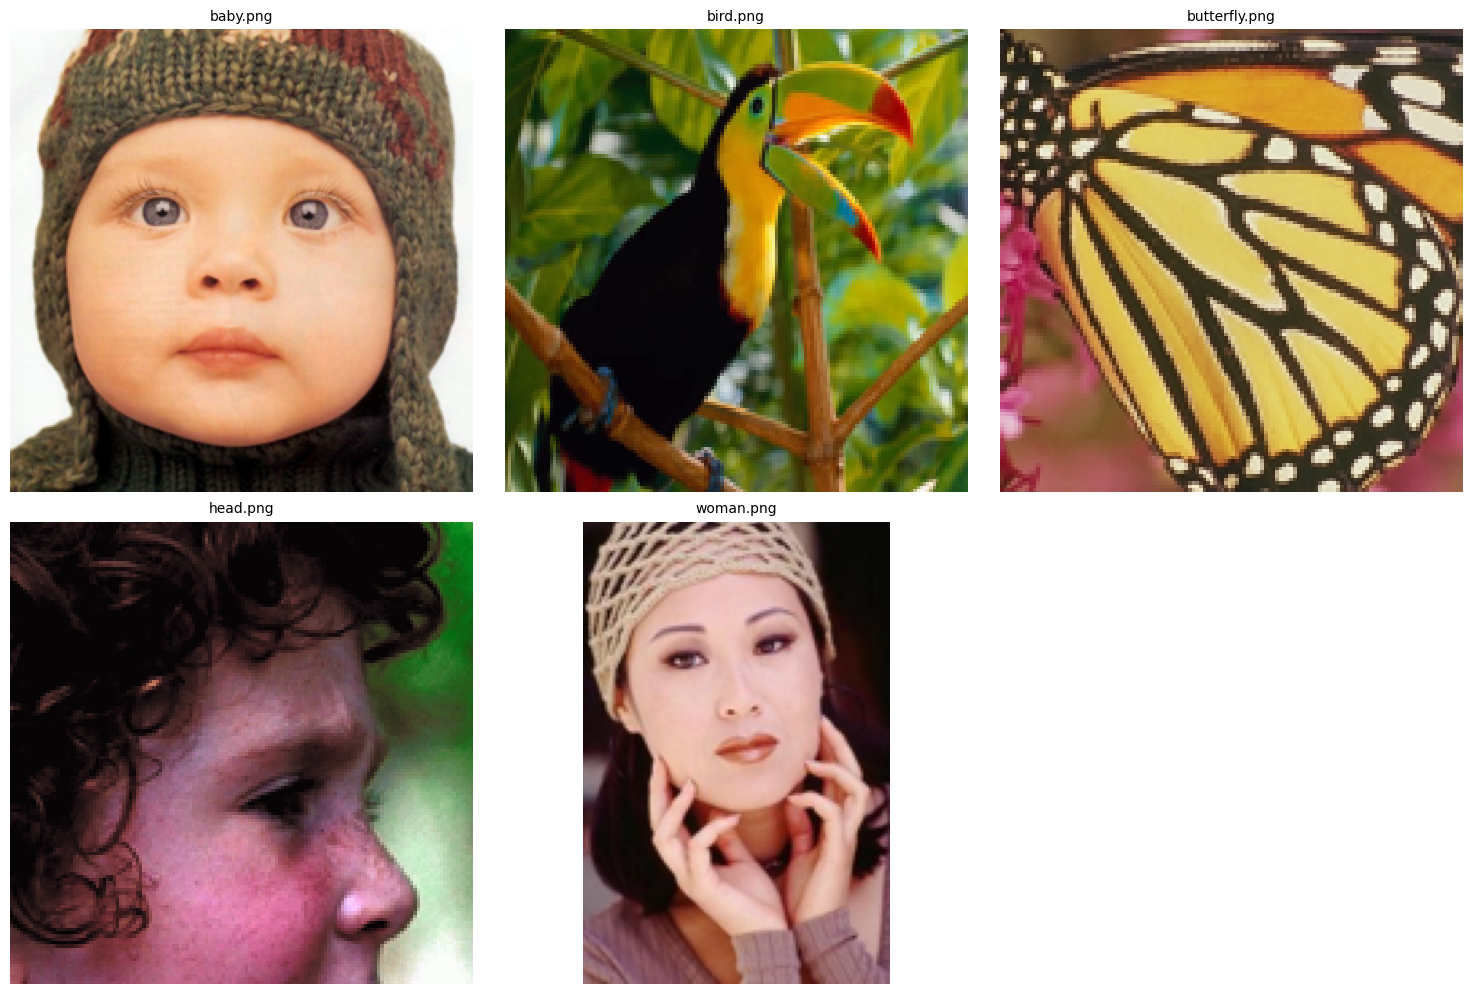

The resolution of the first image is: 256x256


In [15]:
# List of image in the folder I gave with the project code in the following folder path
folder_path = 'Data\Set5_LR_x2'
image_files = [file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

# Display grid
images_per_row = 3
num_images = len(image_files)
num_rows = (num_images + images_per_row - 1) // images_per_row  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, num_rows * 5))

# Displaying
for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    img = Image.open(image_path)
    if i==0:
        first_image_resolution = img.size  
    row = i // images_per_row
    col = i % images_per_row

    axes[row, col].imshow(img)
    axes[row, col].set_title(image_file, fontsize=10)
    axes[row, col].axis('off')
for j in range(i + 1, num_rows * images_per_row):
    row = j // images_per_row
    col = j % images_per_row
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()
print(f"The resolution of the first image is: {first_image_resolution[0]}x{first_image_resolution[1]}")

Comments: These images have rather low-quality, let's see how the model can perform!

##### 1.3 Importing the ESRGAN model

In [11]:
model_path = './pretrained-models/ESRGAN-master/models/RRDB_ESRGAN_x4.pth'
device = torch.device('cpu') ### to be modified if GPU is available

test_img_folder = './pretrained-models/ESRGAN-master/LR/*'

model = RRDBNet(3, 3, 64, 23, gc=32)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
model = model.to(device)

C:\Users\boist\AppData\Local\Temp\ipykernel_5416\1123058.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path), strict=True)


##### 1.4 Application of the model

Model path ./pretrained-models/ESRGAN-master/models/RRDB_ESRGAN_x4.pth. 
Testing...
1 baboon
2 baby
3 bird
4 butterfly
5 comic
6 head
7 model
8 test_p12_
9 woman


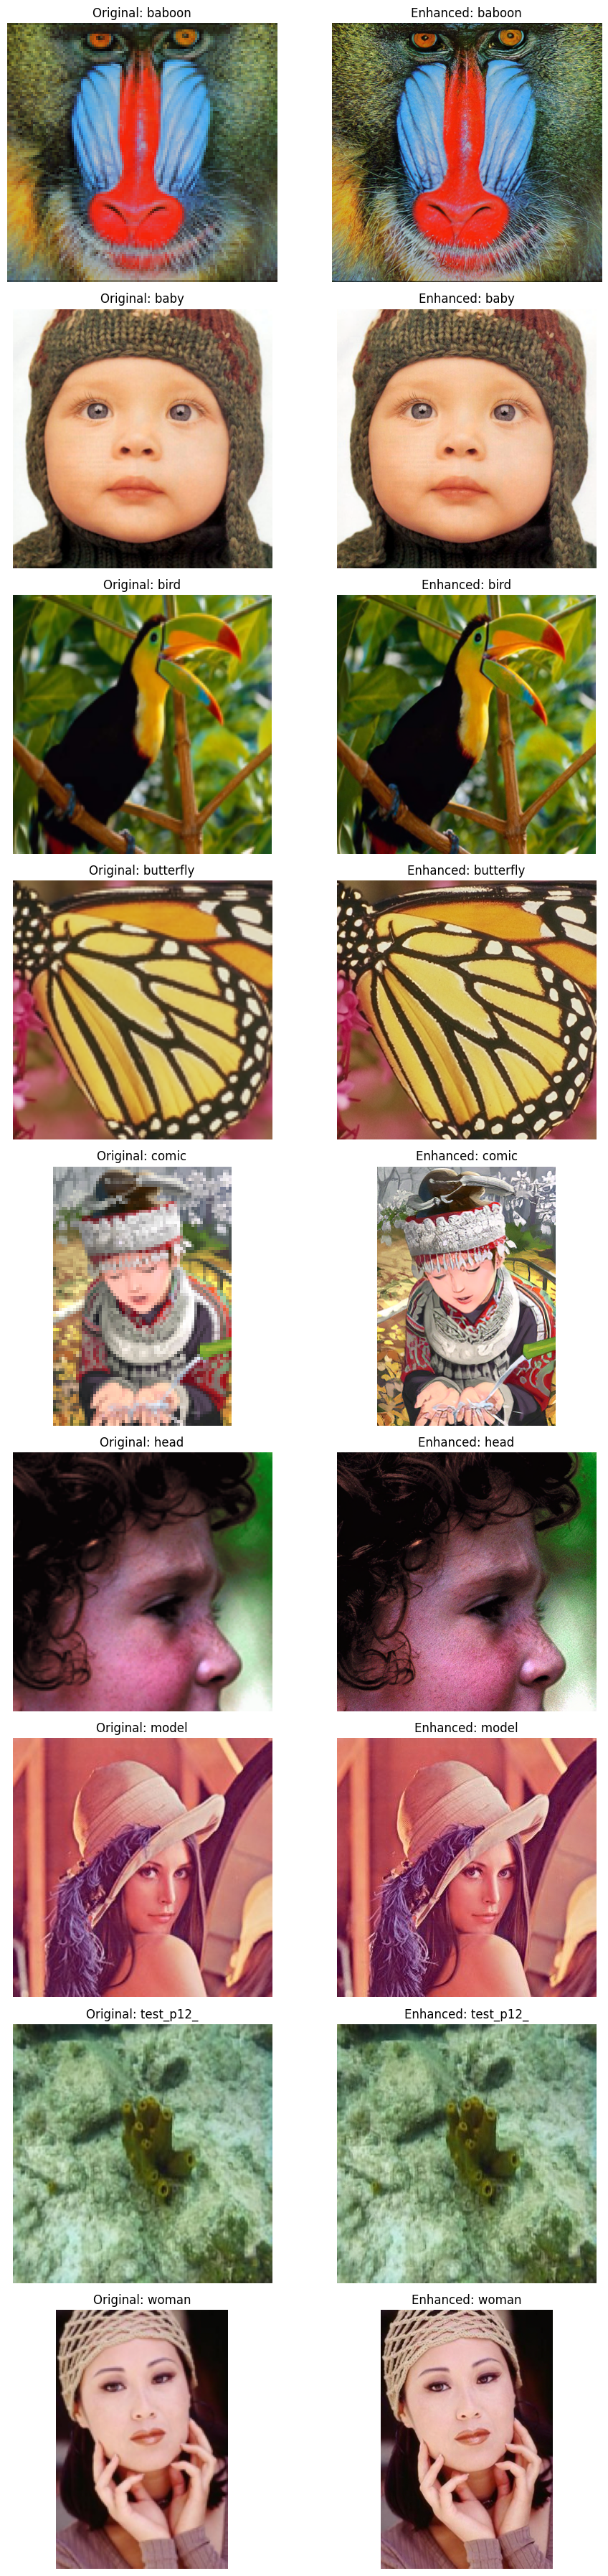

In [16]:
print('Model path {:s}. \nTesting...'.format(model_path))

original_images = []
enhanced_images = []
image_names = []

idx = 0
for path in glob.glob(test_img_folder):
    idx += 1
    base = osp.splitext(osp.basename(path))[0]
    print(idx, base)
    
    # read images
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img * 1.0 / 255
    img_tensor = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
    img_LR = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
    #output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
    output = np.transpose(output, (1, 2, 0))
    
    # Save original and enhanced images for plotting
    original_images.append((img * 255).astype(np.uint8))
    enhanced_images.append((output * 255).astype(np.uint8))
    image_names.append(base)

# Plot grid of original vs enhanced images
num_images = len(original_images)
plt.figure(figsize=(10, 4 * num_images))
for i in range(num_images):
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Original: {image_names[i]}")
    
    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(enhanced_images[i])
    plt.axis('off')
    plt.title(f"Enhanced: {image_names[i]}")

plt.tight_layout()
plt.show()

Comments: we see that the models performs well on the images provided by the authors (baboon and comic), but this pre-trained model lacks generalization abilities, as we can see. More training data should be used. To address this, subsequent models like Real-ESRGAN have been developed to better handle real-world scenarios by incorporating more diverse training data.

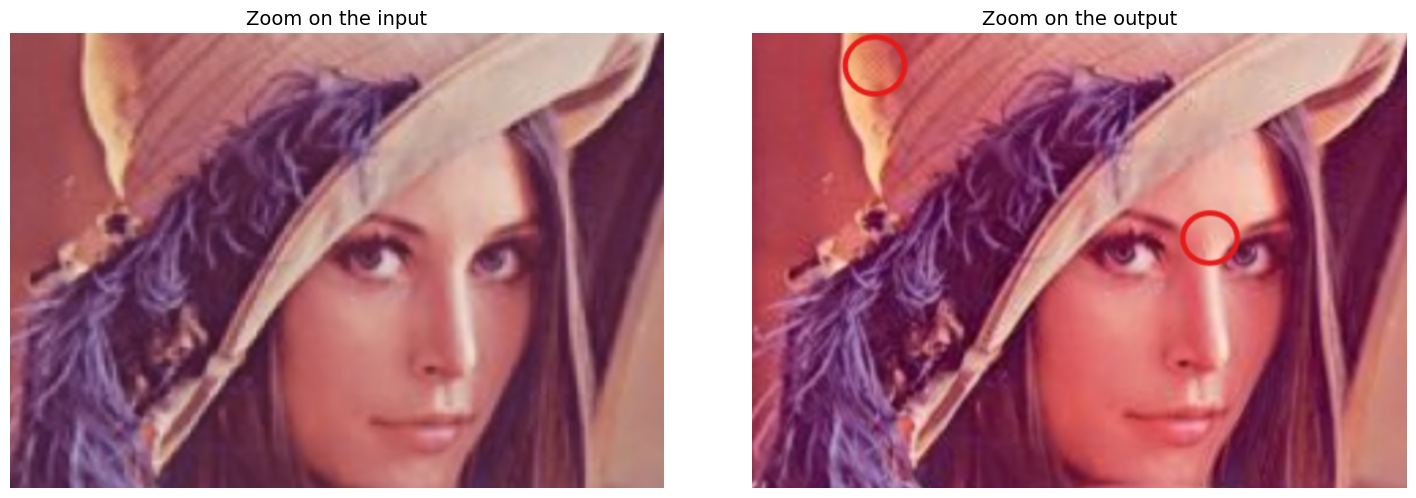

In [27]:
def display_images_side_by_side(folder_path, image_filenames, titles=None):
    num_images = len(image_filenames)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    if num_images == 1:
        axes = [axes]
    
    for i, filename in enumerate(image_filenames):
        image_path = os.path.join(folder_path, filename)
        
        if not os.path.exists(image_path):
            print(f"Image not found: {filename}")
            continue
        
        # Open the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        if titles and i < len(titles):
            axes[i].set_title(titles[i], fontsize=14)
        else:
            axes[i].set_title(filename, fontsize=14)  # Default title is the filename
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

folder_path = "results"
image_filenames = ["model zoom.png", "artifacts model.png"]
titles = ["Zoom on the input", "Zoom on the output"]

display_images_side_by_side(folder_path, image_filenames, titles)